In this notebook we will particepate in the competion of "Home Depot Product Search Relevance".

In this data set we will try yo finding the relevence of the search phrase to the product aimed from that search query. We will Define how much relevence between this two; search pharse vs product intented.
# Our Goal: Founding a connection between search phrase and the product desctiption. 

We will use 2 diffrents views:
1. Task 1: Characteres are the most importent in the search phrase and product description - using LSTM, characters satistics, classic ML.
2. Task 2: Words are the most importent in the search phrase and product description - using word Embeddings, LSTM, word satistics, classic ML.

for each task we will define steps for helping us walk through the deep learning teqchnics we are using. 

Imports for this notebook:

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Embedding, LSTM, Lambda, Dense, Dot, Dropout, Bidirectional, concatenate, Add, Subtract, Flatten, Multiply 
from keras.layers import MaxPooling1D, AveragePooling1D 
from keras.regularizers import l2 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError 
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import gensim 
import re

# Task 1: Character level

## a) Preprocessing the training data and testing data to contain sequences of single characters.
We will do it for for:
1. search phrase
2. item descriptor

For acomplish this section we will need to do couple of things:
1. load test and train data 
2. createing a tokinizer for the search phrase and item descriptor
3. creating a vector presentation for each data of the search phrase and item descriptor using the tokinizer
4. fixing the presentation vectors of the search phrase and item descriptor to same vector size using the tokinizer

### 1. load test and train data

In [ ]:
def load_data():
    product_des = pd.read_csv('../input/home-depot-product-search-relevance/product_descriptions.csv.zip')
    train = pd.read_csv('../input/home-depot-product-search-relevance/train.csv.zip', encoding='ISO-8859-1')
    test = pd.read_csv('../input/home-depot-product-search-relevance/test.csv.zip', encoding='ISO-8859-1')
    test_sol = pd.read_csv('../input/test-solution-ass4/test_solution_ass4.csv')
    test_sol = test_sol[test_sol['relevance']!=-1]
    test_sol = test_sol.drop(['Usage'], axis=1)
    test = test.merge(product_des, on='product_uid', how='left')
    test = test.drop(['product_title'], axis=1)
    test = test_sol.merge(test, on='id', how='left')
    train = train.merge(product_des, on='product_uid', how='left')
    train = train.drop(['product_title'], axis=1)
    return train, test

train, test = load_data()
train.head()

### 2. creating toxenizer character level
we are using 2 functions ;  
* function creating the texts of search phrases and descriptions,
* function creation a tokinizer of character level

In [ ]:
def create_tokonizer_characters(texts):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def create_texts(train, test):
    search_train = train['search_term'].to_numpy()
    search_test = test['search_term'].to_numpy()
    search_texts = np.concatenate([search_train,search_test])
    des_train = train['product_description'].to_numpy()
    des_test = test['product_description'].to_numpy()
    des_texts = np.concatenate([des_train,des_test])
    text = np.concatenate([search_texts,des_texts])
    return text

text = create_texts(train, test)
char_tk = create_tokonizer_characters(text)
print(char_tk.word_index.keys())

### 3. creating vectors presentation from tokonizers
Changing the presentation of each search phrase and description to character level vector from the tokinizer we created

In [ ]:
def train_test_from_tk(train, test, search_tk, des_tk):
    train['search_term'] = search_tk.texts_to_sequences(train['search_term'])
    train['product_description'] = des_tk.texts_to_sequences(train['product_description'])
    test['search_term'] = search_tk.texts_to_sequences(test['search_term'])
    test['product_description'] = des_tk.texts_to_sequences(test['product_description'])
    return train, test

train, test = train_test_from_tk(train, test, char_tk, char_tk)
train.head()

### 4. fixing the presentation vectors - Creating X,y for train and test sets 
For using the vector presentation in cnn we need to pad each search phrase and description to the same size. 
We will use a function for analyzing the vector sizes and get min_max_avg for both train, test sets.

In [ ]:
def find_min_max_avg(A, B):
    s_min = -1
    s_max = -1
    s_sum = 0
    for a in A:
        size = len(a)
        s_sum += size
        if s_min == -1 or s_min > size:
            s_min = size
        if s_max == -1 or s_max < size:
            s_max = size
    for b in B:
        size = len(b)
        s_sum += size
        if s_min == -1 or s_min > size:
            s_min = size
        if s_max == -1 or s_max < size:
            s_max = size
    s_avg = int(s_sum / (len(A) + len(B)))
    return s_min, s_max, s_avg

des_min, des_max, des_avg = find_min_max_avg(train['product_description'],test['product_description'])
print('vector analyzes for product description: min=', des_min, ' ,max=',des_max, ' ,avg=', des_avg)

search_min, search_max, search_avg = find_min_max_avg(train['search_term'],test['search_term'])
print('vector analyzes for search term: min=', search_min, ' ,max=', search_max, ' ,avg=', search_avg)

In [ ]:
def create_X_y_with_padding(train, test, maxlen_search, maxlen_des):
    X_train = train.copy().drop(['id','product_uid','relevance'], axis=1)
    X_train['search_term'] = [x for x in pad_sequences(train['search_term'], maxlen=maxlen_search, padding='post')]
    X_train['product_description'] = [x for x in pad_sequences(train['product_description'], maxlen=maxlen_des, padding='post')]
    y_train = train.copy()['relevance']
    
    X_test = test.copy().drop(['id','product_uid','relevance'], axis=1)
    X_test['search_term'] = [x for x in pad_sequences(test['search_term'], maxlen=maxlen_search, padding='post')]
    X_test['product_description'] = [x for x in pad_sequences(test['product_description'], maxlen=maxlen_des, padding='post')]
    y_test = test.copy()['relevance']
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    print('X train shape: ',X_train.shape, ' y train shape: ', y_train.shape)
    print('X val shape: ',X_val.shape, ' y val shape: ', y_val.shape)
    print('X test shape: ',X_test.shape, ' y test shape: ', y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

maxlen_size = des_avg
if search_avg > des_avg:
    maxlen_size = search_avg 
X_train, y_train, X_val, y_val, X_test, y_test = create_X_y_with_padding(train, test, maxlen_size, maxlen_size)

## b) Building a Siamese network. 
The input of the network will be the search phrase and the item descriptor.
The output of the network will be search relevance score. 

we will define the callbacks, metrics, and help function for converting the X data to 2 inputs easly,

In [ ]:
def create_callbacks(name):
    early_stopping = EarlyStopping(patience=3)
    cheak_point = ModelCheckpoint(name)
    return [early_stopping, cheak_point]

def create_metrics():
    # [meanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()]
    return [RootMeanSquaredError(), MeanAbsoluteError()]

def create_x_inputs(X):
    X_search = np.array(list(x for x in X['search_term']))
    X_des = np.array(list(x for x in X['product_description'])) 
    return X_search, X_des

This section we used bulding the network. The Siamese network is using the same model in each input chanle we have, and then combining these output from the models to one result.

In [ ]:
def create_input_1(map_size, name, input_shape=(1,)):
    inp = Input(shape=input_shape, dtype='int32', name='input_'+name)
    emb = Embedding(map_size, 32, embeddings_regularizer=l2(1e-6), name='embedding_'+name)(inp)
    x = Dense(32, activation='relu', name='dense_1_'+name)(emb)
    x = Bidirectional(LSTM(16, name='lstm_1_'+name), name='Bidirctional_1_'+name)(x)
    return inp, x

def create_model_1(map_size_search, map_size_des):
    search_inp, search = create_input_1(map_size_search, 'search')
    des_inp, des = create_input_1(map_size_des, 'des')
    x = Dot(axes=-1, normalize=True, name ='dot')([search, des])
    x = Lambda(lambda x: 3*x, name='shift_result')(x)
    return Model(inputs=[search_inp, des_inp], outputs=x, name='model_1')

model1 = create_model_1(len(char_tk.word_index)+1, len(char_tk.word_index)+1)
model1.compile(loss='mse',optimizer='adam', metrics=create_metrics())
model1.summary()

Training Model 1:

In [ ]:
%%time
callbacks = create_callbacks('./model1.h5')
X_search, X_des = create_x_inputs(X_train)
X_search_val, X_des_val = create_x_inputs(X_val)
history = model1.fit([X_search,X_des], y_train, validation_data=([X_search_val, X_des_val],y_val), epochs=10, 
                     batch_size=64, callbacks=callbacks)

View Model 1 Results.

We created a quick plot functoin for all the loss metrics we used - mse, rmse, mae

In [ ]:
def quick_plot_loss(history, field, loss_name, ax):
    # Plot training & validation loss values
    ax.plot(history.history[field])
    ax.plot(history.history['val_'+field])
    ax.set_title('Model loss '+loss_name)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')
                
    
def quick_plot_history(history):
    fig = plt.figure(figsize=(18, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('mse')
    quick_plot_loss(history, 'loss', 'mse', ax)
    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('rmse')
    quick_plot_loss(history, 'root_mean_squared_error', 'rmse', ax)
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('rmae')
    quick_plot_loss(history, 'mean_absolute_error', 'mae', ax)
    
quick_plot_history(history)

See how Model 1 results on test set:

In [ ]:
def show_results(preds, y, set_name='test'):
    print('model mse loss on '+set_name+' set :',mean_squared_error(y, preds))
    print('model rmse loss on '+set_name+' set :',mean_squared_error(y, preds, squared=False))
    print('model mae loss on '+set_name+' set :',mean_absolute_error(y, preds))

model1 = load_model('./model1.h5')
X_search, X_des = create_x_inputs(X_test)
preds = model1.predict([X_search,X_des])
show_results(preds, y_test)

## c) Creating a benchmark - Using a count vectorizer.

we will need to do couple of things:
1. load the data for train and test
2. creating Counting tokonizer
3. creating new vector presentation of the data 
4. creating base model for this problem - fully connected model
5. training the model and view the results

### 1. load the data for train and test

In [ ]:
train, test = load_data()

### 2. creating Counting tokonizer
Note: This embedding of the characters is a naive one for how many times they are in the search term and the description.

In [ ]:
def create_count_tokonizer(train, test):
    train_curpus = train['search_term'].to_numpy() + train['product_description'].to_numpy() 
    test_curpus = test['search_term'].to_numpy() + test['product_description'].to_numpy()
    curpus = np.concatenate([train_curpus, test_curpus])
    tokinizer = CountVectorizer(analyzer='char_wb')
    tokinizer.fit_transform(curpus)
    return tokinizer

counting_tk = create_count_tokonizer(train,test)

### 3. creating new vector presentation of the data 

In [ ]:
def create_X_y_with_counting(train, test):
    X_train = train.copy().drop(['id','product_uid','relevance'], axis=1)
    X_train['search_term'] = [np.squeeze(counting_tk.transform([x]).toarray()) for x in train['search_term']]
    X_train['product_description'] = [np.squeeze(counting_tk.transform([x]).toarray()) for x in train['product_description']]
    y_train = train.copy()['relevance']
    
    X_test = test.copy().drop(['id','product_uid','relevance'], axis=1)
    X_test['search_term'] = [np.squeeze(counting_tk.transform([x]).toarray()) for x in test['search_term']]
    X_test['product_description'] = [np.squeeze(counting_tk.transform([x]).toarray()) for x in test['product_description']]
    y_test = test.copy()['relevance']
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    print('X train shape: ',X_train.shape, ' y train shape: ', y_train.shape)
    print('X val shape: ',X_val.shape, ' y val shape: ', y_val.shape)
    print('X test shape: ',X_test.shape, ' y test shape: ', y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = create_X_y_with_counting(train, test)
X_train.head()

### 4. creating base model for this problem - fully connected model

In [ ]:
def create_model_3(vector_size):
    inp_search = Input(shape=(vector_size), name ='input_search' ,dtype='int32')
    search = Dense(32 ,activation='relu', name='dense_search_1')(inp_search)
    search = Dense(64 ,activation='relu', name='dense_search_2')(search)
    inp_des = Input(shape=(vector_size), name ='input_des',dtype='int32')
    des = Dense(32 ,activation='relu', name='dense_des_1')(inp_des)
    des = Dense(64 ,activation='relu', name='dense_des_2')(des)
    x = Dot(axes=-1, normalize=True, name ='dot')([search, des])
    x = Lambda(lambda x: 3*x, name='shift_result')(x)
    x = Model(inputs=[inp_search,inp_des], outputs=x)
    return x

vector_size = len(counting_tk.vocabulary_.keys()),
model3 = create_model_3(vector_size)
model3.compile(loss='mse',optimizer='adam', metrics=create_metrics())
model3.summary()

### 5. training the model and view the results

In [ ]:
%%time
callbacks = create_callbacks('./model3.h5')
X_search, X_des = create_x_inputs(X_train)
X_search_val, X_des_val = create_x_inputs(X_val)
history = model3.fit([X_search,X_des], y_train, validation_data=([X_search_val, X_des_val],y_val), epochs=10, 
                     batch_size=64, callbacks=callbacks)

In [ ]:
quick_plot_history(history)

In [ ]:
X_search, X_des = create_x_inputs(X_test)
model3 = load_model('./model3.h5')
preds = model3.predict([X_search,X_des])
show_results(preds, y_test)

## d) Creating a Feature Extractor to our model using classic ML algorithem. 
We will use 2 ML: random forest & catboost

Loading the data for the using model1

In [ ]:
train, test = load_data()
train, test = train_test_from_tk(train, test, char_tk, char_tk)
X_train, y_train, X_val, y_val, X_test, y_test = create_X_y_with_padding(train, test, search_avg, des_avg)

In [ ]:
model1 = load_model('./model1.h5')
X_search, X_des = create_x_inputs(X_train)
preds_train = model1.predict([X_search, X_des])

### catboost - linear regression

In [ ]:
%%time
model4 = CatBoostRegressor(iterations=10, learning_rate=1)
model4.fit(preds_train, y_train)

In [ ]:
preds = model4.predict(preds_train)
show_results(preds, y_train, set_name='train')

X_search, X_des = create_x_inputs(X_val)
preds = model1.predict([X_search, X_des]) 
preds = model4.predict(preds)
show_results(preds, y_val, set_name='val')
    
X_search, X_des = create_x_inputs(X_test)
preds = model1.predict([X_search, X_des])    
preds = model4.predict(preds)
show_results(preds, y_test)

### Random forest

In [ ]:
%%time
model5 = RandomForestRegressor(n_estimators = 81, max_depth = 18)
model5.fit(preds_train,y_train)

In [ ]:
preds = model5.predict(preds_train)
show_results(preds, y_train, set_name='train')

X_search, X_des = create_x_inputs(X_val)
preds = model1.predict([X_search, X_des]) 
preds = model5.predict(preds)
show_results(preds, y_val, set_name='val')
    
X_search, X_des = create_x_inputs(X_test)
preds = model1.predict([X_search, X_des])    
preds = model5.predict(preds)
show_results(preds, y_test)

# Task 2: Word level

## a) Preprocessing the data to create tokens of words/character-combinations 
same as task1 we will do it for:
* search phrase
* product description

for acomplish this section we will need to do couple of things:
1. load the data
2. spliting all the text phrase and description to vector of tokens 

### 1. + 2. loading the data and spliting all the text phrase and description to vector of tokens
In this section we will take each search phrase and each product description and split it to token of words.

In [ ]:
def to_tokens(text):
    text = text.replace(' ', ',')
    text = text.replace('.', ',')
    text = text.replace('\n', ',')
    text = text.replace(';', ',')
    return text.split(',')

def split_search_description(train, test):
    train['search_term'] = [to_tokens(x) for x in train['search_term']]
    test['search_term'] = [to_tokens(x) for x in test['search_term']]
    train['product_description'] = [to_tokens(x) for x in train['product_description']]
    test['product_description'] = [to_tokens(x) for x in test['product_description']]
    return train, test

train, test = load_data()
train, test = split_search_description(train, test)
train.head()

## b) Creating an Word Embedding for all the desired words from prev section
for the mebedding we need couple of things:
1. createing word tokenizer
2. creating word vectors for each search phrase and description
3. analyze the sizes of the vectors and decide same vector size
4. we will use Embedding layer for each word vector we have from search phrase and description as part as our Model.

### 1. creating word tokonizer from our data

In [ ]:
def create_tokonizer_word(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer

train_word, test_word = load_data()
text = create_texts(train_word, test_word)
word_tk = create_tokonizer_word(text)
print('numeber of diffrent words in the texts: ', len(word_tk.word_index.keys()))

### 2. + 3. creating word vectors form our tokenizer and analyzing the sizes of the vectors

In [ ]:
train, test = train_test_from_tk(train, test, word_tk, word_tk)
des_min, des_max, des_avg = find_min_max_avg(train['product_description'],test['product_description'])
print('vector analyzes for product description: min=', des_min, ' ,max=',des_max, ' ,avg=', des_avg)

search_min, search_max, search_avg = find_min_max_avg(train['search_term'],test['search_term'])
print('vector analyzes for search term: min=', search_min, ' ,max=', search_max, ' ,avg=', search_avg)

maxlen_size = des_avg
if search_avg > des_avg:
    maxlen_size = search_avg 
X_train, y_train, X_val, y_val, X_test, y_test = create_X_y_with_padding(train, test, maxlen_size, maxlen_size)

In [ ]:
X_train.head()

### 4. We will use in our model an embedding layer for search phrase and product description

## c) Building a Siamese network.
The input of the network will be the the words/character-combinations constructing the search phrase and the item descriptor.

The output of the network will be search relevance score. 

Model 6:

In [ ]:
def create_input_6(map_size, name, input_shape=(1,)):
    inp = Input(shape=input_shape, dtype='int32', name='input_'+name)
    emb = Embedding(map_size, 8, embeddings_regularizer=l2(1e-6), name='embedding_'+name)(inp)
    x = Bidirectional(LSTM(16, name='lstm_1_'+name), name='Bidirctional_1_'+name)(emb)
    x = Dense(32, activation='relu', name='dense_1_'+name)(x)
    x = Dense(64, activation='relu', name='dense_2_'+name)(x)
    return inp, x

def create_model_6(map_size):
    search_inp, search = create_input_6(map_size, 'search')
    des_inp, des = create_input_6(map_size, 'des')
    x = Dot(axes=-1, normalize=True, name ='dot')([search, des])
    x = Lambda(lambda x: 3*x, name='shift_result')(x)
    return Model(inputs=[search_inp, des_inp], outputs=x, name='model_6')

model6 = create_model_6(len(word_tk.word_index)+1)
model6.compile(loss='mse',optimizer='adam', metrics=create_metrics())
model6.summary()

Model 6 training:

In [ ]:
%%time
callbacks = create_callbacks('./model6.h5')
X_search, X_des = create_x_inputs(X_train)
X_search_val, X_des_val = create_x_inputs(X_val)
history = model6.fit([X_search,X_des], y_train, validation_data=([X_search_val, X_des_val],y_val), epochs=10, 
                     batch_size=64, callbacks=callbacks)

Model 6 results:

In [ ]:
quick_plot_history(history)

we can see our model 6 is  in overfitting

Model 6 results of testing set

In [ ]:
X_search, X_des = create_x_inputs(X_test)
model6 = load_model('./model6.h5')
preds = model6.predict([X_search,X_des])
show_results(preds, y_test)

We will try to improve Model 6, with Model 7

In [ ]:
def create_input_7(map_size, name, input_shape=(1,)):
    inp = Input(shape=input_shape, dtype='int32', name='input_'+name)
    emb = Embedding(map_size, 32, embeddings_regularizer=l2(1e-6), name='embedding_'+name)(inp)
    x = Bidirectional(LSTM(16, name='lstm_1_'+name), name='Bidirctional_1_'+name)(emb)
    x = Dense(32, activation='relu', name='dense_1_'+name)(x)
    x = Dense(64, activation='relu', name='dense_2_'+name)(x)
    x = Dense(128, activation='relu', name='dense_3_'+name)(x)
    return inp, x

def create_model_7(map_size):
    search_inp, search = create_input_7(map_size, 'search')
    des_inp, des = create_input_7(map_size, 'des')
    x = Dot(axes=-1, normalize=True, name ='dot')([search, des])
    x = Lambda(lambda x: 3*x, name='shift_result')(x)
    return Model(inputs=[search_inp, des_inp], outputs=x, name='model_7')

model7 = create_model_7(len(word_tk.word_index)+1)
model7.compile(loss='mse',optimizer='adam', metrics=create_metrics())
model7.summary()

Model 7 training:

In [ ]:
%%time
callbacks = create_callbacks('./model7.h5')
X_search, X_des = create_x_inputs(X_train)
X_search_val, X_des_val = create_x_inputs(X_val)
history = model7.fit([X_search,X_des], y_train, validation_data=([X_search_val, X_des_val],y_val), epochs=10, 
                     batch_size=64, callbacks=callbacks)

Model 7 results:

In [ ]:
quick_plot_history(history)

we can see model 7 is in overfitting

Model 7 results on testing set

In [ ]:
X_search, X_des = create_x_inputs(X_test)
model7 = load_model('./model7.h5')
preds = model7.predict([X_search,X_des])
show_results(preds, y_test)

## d) Creating a Feature Extractor to our model using classic ML algorithem. 
We will use 2 ML: random forest & catboost

In [ ]:
X_search, X_des = create_x_inputs(X_train)
preds_train = model7.predict([X_search, X_des])

### catboost - linear regression

In [ ]:
%%time
model8 = CatBoostRegressor(iterations=10, learning_rate=1)
model8.fit(preds_train, y_train)

In [ ]:
preds = model8.predict(preds_train)
show_results(preds, y_train, set_name='train')

X_search, X_des = create_x_inputs(X_val)
preds = model7.predict([X_search, X_des]) 
preds = model8.predict(preds)
show_results(preds, y_val, set_name='val')
    
X_search, X_des = create_x_inputs(X_test)
preds = model7.predict([X_search, X_des])    
preds = model8.predict(preds)
show_results(preds, y_test)

### Random forest

In [ ]:
%%time
model9 = RandomForestRegressor(n_estimators = 81, max_depth = 18)
model9.fit(preds_train,y_train)

In [ ]:
preds = model9.predict(preds_train)
show_results(preds, y_train, set_name='train')

X_search, X_des = create_x_inputs(X_val)
preds = model7.predict([X_search, X_des]) 
preds = model9.predict(preds)
show_results(preds, y_val, set_name='val')
    
X_search, X_des = create_x_inputs(X_test)
preds = model7.predict([X_search, X_des])    
preds = model9.predict(preds)
show_results(preds, y_test)

# Task 3: Comparing the results of prev models.

## Table of results Task 1 - character embedding
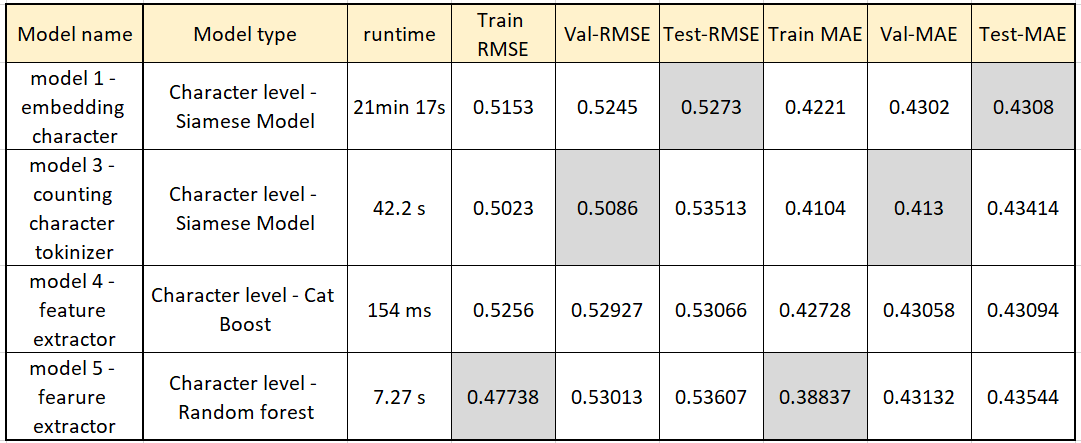

We can see that our model 1 is the best on the test set, while model 2 is the best of the validation set, and model 5 is the best on train set.
So model 1 is our best model for the first task.

We can see model 1 is better then our bench mark, model 3.

## Table of results Task 2 - word embedding
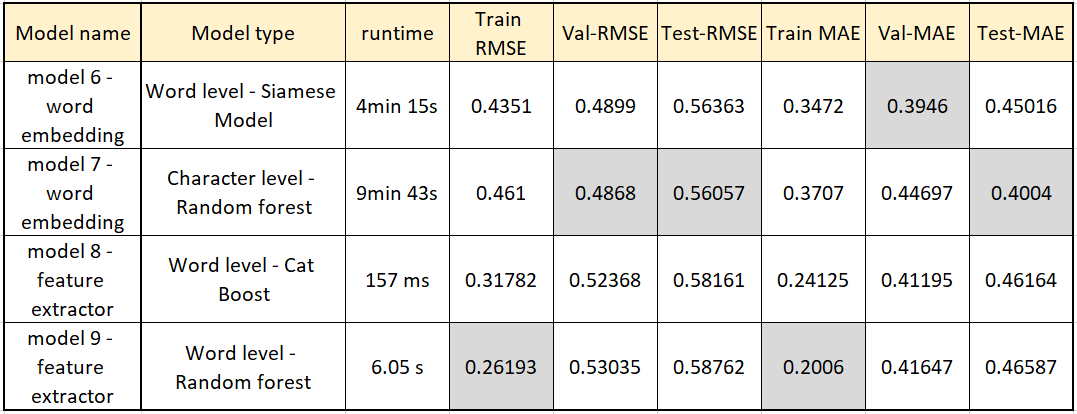

We can see that model 7 is the best model in this task.

# Summary

In this notebook we walk through how we are doing word/character embedding for finding the amount of relevence between the search phrase and product description.

We saw how to create tokenizers - charater tokenizer, counting tokenizer, word tokenizer.

We saw that definig a strong bench mark is importent to see how our models doing.  

Also we saw how the use of help functions improving our work and make it more readeable.  

# Final Remarks
* Its seen that the models who took the most time to train are the best models results on the test set at each task
* Our word models resuls almost the same as our characters models
* Ways to improve our results:
    1. For improving our results we can use more features of the data - product title, product attributes (we only used search phrase and product description)
    2. using pre tranied models to help us solve this problem.
    3. using hyper parameters to improve our model.